In [15]:
import torch
from torch import nn as nn
from torch.autograd import Variable
from torch import optim as optim
from torch.nn import functional as F

import numpy as np

import sys

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
# # Simulation
# from scipy.special import expit as sigmoid
# from scipy.stats import norm
# n = 1000
# p = 1
# X = np.random.randn(n,p) #standard normal distribution
# z_real =  np.array([-2])
# y = np.random.binomial(1,sigmoid(np.dot(X,z_real)))


# #lets take p =1 t0 make it simple. 

$$
    z \sim \mathcal{N}(0,\mathbf{I}_p)
$$
$$
    \mathbf{x}_k \sim \mathcal{N}(0,\mathbf{I}_p) \qquad\mathrm{[fixed(?)]}
$$
$$
    y_k\,|\,z,\mathbf{x}_k \sim \pi(\Phi(z\cdot\mathbf{x}_k))
$$

In [3]:
n = 1000 # num. samples
p = 2    # dimension of z

In [4]:
X = torch.randn((n,p))
z_true = torch.randn((p,1))

p_y = lambda z,x: torch.distributions.Binomial(
    probs=torch.sigmoid((x @ z).mean(1))
)

y = p_y(z_true, X).sample()

In [5]:
z_true

tensor([[0.6539],
        [0.2839]])

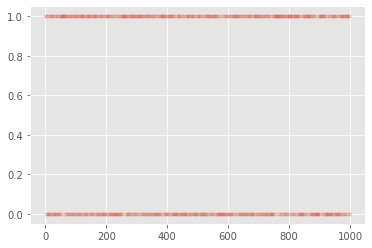

In [6]:
plt.plot(y,'.',alpha=0.1)

In [33]:
class VAE(nn.Module):
    '''
    X : Tensor nxp given
    y : Tensor n given
    z : Tensor s x p (s=number of sample , z~q(z|y,x) distribution)
    '''
    def __init__(self, likelihood=None, encoder=None):
        super(VAE, self).__init__()
        
#         self.mu       = nn.Parameter(
#             torch.randn(p,1), requires_grad=True
#         ) # THIS IS DEPENDENT ON Y: MU=ENCODER(Y), so not a parameter

        self.logsigma = nn.Parameter(
            torch.randn(p,1), requires_grad=True
        )
        
        if likelihood is None:
            self.likelihood = lambda z,x: torch.distributions.Binomial(
                probs=torch.sigmoid(x @ z)
            )
        else:
            self.likelihood
            
        self.encoder = self._encoder if encoder is None else encoder
        
        #prior
        self.dim = p
        self.prior_m  = Variable(
            torch.zeros(p,1), requires_grad=False
        )
        self.prior_log_sigma = Variable(
            torch.ones(p,1), requires_grad=False # should this be zero ?
        )
        
    def _encoder(self, y):
        ''' Default encoder '''
        # There needs to be some form of parametric model for this otherwise there's nothing to optimise here
        p  = y.mean() #estimator
        mu = p.log()-(1-p).log()
        
        return mu
    
    def reparam(self, mu):
        epsilon = torch.distributions.Normal(0,1).sample()
        sigma   = torch.exp(self.logsigma) #self.logsigma.exp()
        return eps*sigma + self.mu
#         return  eps.mul(sigma).add(self.mu)
    
    
    def decoder(self,z,X):
        ''' white decoder: p(y|z,X) = Bern(Φ(z.x))'''
        return self.likelihood(z, X).sample()
    
    def loss_function(self, q_log_likelihood ,log_prior, recon_y, y ):
        ''' L = log p(y) - log q(y) - H[y',y]'''
        KLD = q_log_likelihood - log_prior
        BCE = F.binary_cross_entropy(recon_y, y, reduction ='sum')
        return BCE + KLD
    
    def forward(self, y, X):
        ''' Evaluate model
        
            μ = encoder(y)
            z ~ N(μ, σ2) [= μ + ϵ.σ]
            
        '''
        
        self.mu     = self.encoder(y)
        sigma       = self.logsigma.exp()
        
        prior_sigma = self.prior_log_sigma.exp()
        
        q_z         = torch.distributions.Normal(self.mu,sigma)
        p_z         = torch.distributions.Normal(self.prior_m, prior_sigma)
        
        z = q_z.sample()
    
        
        recon_y = self.decoder(z, X)
        
        loss = self.loss_function(
            q_z.log_prob(z).sum(0).mean(),
            p_z.log_prob(z).sum(0).mean(),
            recon_y,
            y
        )
        
        return loss

In [34]:
model = VAE() # default encoder and likelihood
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

err = lambda mu: ((mu - z_true)**2).mean()

losses = []

for i in range(10000):
    loss = model(y, X)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
#     if i % 200 ==0:
    mu = model.mu.data
    losses.append(loss.data.numpy())
    sys.stdout.write('\r%3d/10000 : loss=%10.5f ; mu=%s ; mse=%10.5f' % (i+1, loss.data.numpy(), str(mu.numpy().ravel()), err(mu).item()))
    sys.stdout.flush()

C:\Users\Wil_User\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])) is deprecated. Please ensure they have the same size.


10000/1000 : loss=13182.21484 ; mu=[0.0680263] ; mse=   0.19493

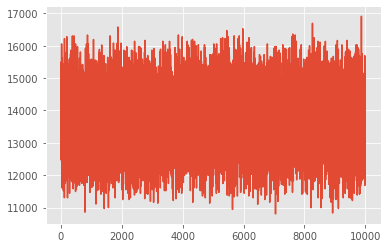

In [32]:
plt.plot(losses)